In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 8.2 MB/s 


In [ ]:
import pandas as pd
import torch
import random
import numpy as np
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from deap import creator, base, tools, algorithms
from numpy import genfromtxt
import torch.nn.functional as F
from numpy import genfromtxt
import math,torch
from sympy.combinatorics.graycode import bin_to_gray
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

In [ ]:
red_patch = mpatches.Patch(color='red', label='training')
blue_patch = mpatches.Patch(color='blue', label='testing')

In [ ]:
# formula we are trying to predict, and generate op
def theformula(x1,x2):
    return math.sin(3.5*x1 + 1.0)*math.cos(5.5*x2)

# function for generating the dataset
def generateData(size):
    x1 = np.random.uniform(low=-1, high=1, size=(size,))
    print("-> ",type(x1))
    x2 = np.random.uniform(low=-1, high=1, size=(size,))
    y = [theformula(i,j) for i,j in zip(x1,x2)]
    data = pd.DataFrame([x1,x2,y]).transpose()
    data.columns=["x1","x2","y"]
    return data

data = generateData(1100)
data

->  <class 'numpy.ndarray'>


,x1,x2,y
0,-0.396896,-0.754321,0.202690
1,-0.513692,0.971863,-0.423426
2,0.578106,-0.682661,-0.096470
3,-0.722674,-0.699845,0.759303
4,0.280972,0.180443,0.500777
...,...,...,...
1095,-0.801217,-0.992713,-0.661388
1096,0.442815,-0.005582,0.557542
1097,0.251702,-0.926907,0.358166
1098,-0.369071,0.010788,-0.287123


1.1

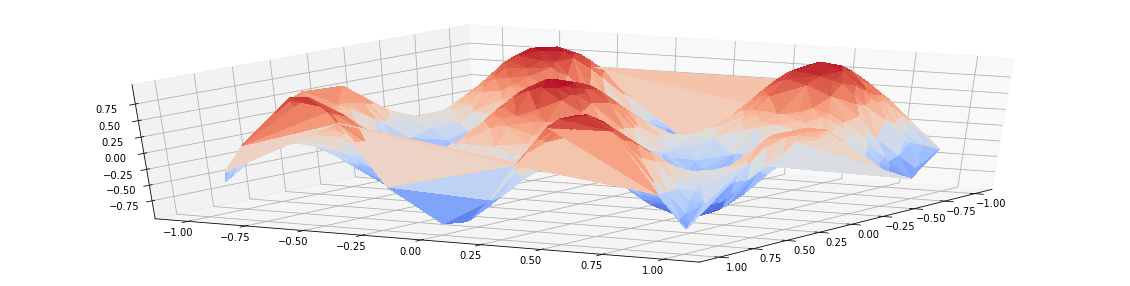

In [ ]:
fig = plt.figure(figsize=(20,5))
# surface_plot with color grading and color bar
ax = plt.axes(projection ="3d")
ax.plot_trisurf(data['x1'], data['x2'], data['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
ax.view_init(30,30)

1.2

In [ ]:
# getting train and test dataset
train = data.head(1000)
test = data.tail(100)
train.shape,test.shape

((1000, 3), (100, 3))

Text(0.5, 0.92, 'Test dataset')

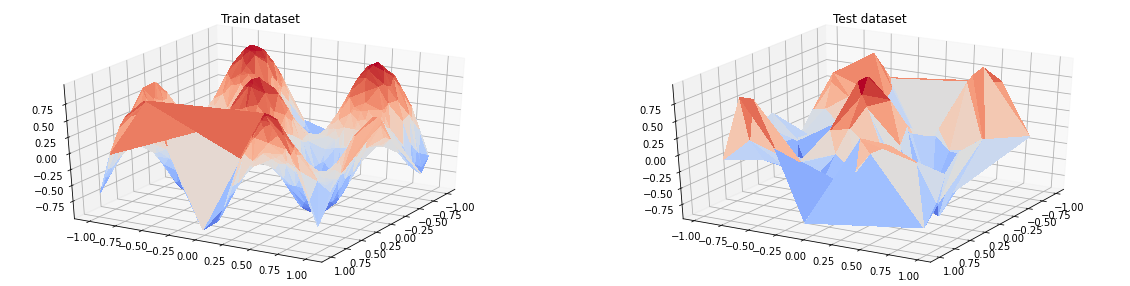

In [ ]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(train['x1'], train['x2'], train['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
ax.view_init(30,30)
plt.title("Train dataset")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(test['x1'], test['x2'], test['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
ax.view_init(30,30)
plt.title("Test dataset")

1.3

In [ ]:
class Net(torch.nn.Module):
    # initialise two hidden layers and one output layer
    def __init__(self, n_feature, n_hidden1,n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden1)  # 1st hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)  # 2nd hidden layer
        self.out = torch.nn.Linear(n_hidden2, n_output)  # output layer
        

    # foward propagation, input -> hidden -> out
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))  # activation function(sigmoid)
        x = torch.sigmoid(self.hidden2(x)) 
        x = self.out(x) # (linear layer)
        return x
    
mynet = Net(n_feature=2, n_hidden1=6,n_hidden2=6, n_output=1)
mynet

Net(
  (hidden): Linear(in_features=2, out_features=6, bias=True)
  (hidden2): Linear(in_features=6, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=1, bias=True)
)

1.4

In [ ]:
weights = np.linspace(0, 1, 67)
weights

array([0.        , 0.01515152, 0.03030303, 0.04545455, 0.06060606,
       0.07575758, 0.09090909, 0.10606061, 0.12121212, 0.13636364,
       0.15151515, 0.16666667, 0.18181818, 0.1969697 , 0.21212121,
       0.22727273, 0.24242424, 0.25757576, 0.27272727, 0.28787879,
       0.3030303 , 0.31818182, 0.33333333, 0.34848485, 0.36363636,
       0.37878788, 0.39393939, 0.40909091, 0.42424242, 0.43939394,
       0.45454545, 0.46969697, 0.48484848, 0.5       , 0.51515152,
       0.53030303, 0.54545455, 0.56060606, 0.57575758, 0.59090909,
       0.60606061, 0.62121212, 0.63636364, 0.65151515, 0.66666667,
       0.68181818, 0.6969697 , 0.71212121, 0.72727273, 0.74242424,
       0.75757576, 0.77272727, 0.78787879, 0.8030303 , 0.81818182,
       0.83333333, 0.84848485, 0.86363636, 0.87878788, 0.89393939,
       0.90909091, 0.92424242, 0.93939394, 0.95454545, 0.96969697,
       0.98484848, 1.        ])

In [ ]:
def weightsIntoNetwork(weights):
    weights = np.array(weights) #make sure the weights are np.arrays
    
    # reshaping the weights to match the layers
    hidden_layer =   torch.FloatTensor(weights[:12].reshape(6,2)) # 12
    hidden_layer_2 =   torch.FloatTensor(weights[12:48].reshape(6,6)) # 36
    output_layer =   torch.FloatTensor(weights[48:54].reshape(1,6)) # 6

    # reshaping weights to match biases
    hidden_bias = torch.FloatTensor(weights[54:60])
    hidden_bias_2 = torch.FloatTensor(weights[60:66])
    out_p_bias = torch.FloatTensor(weights[66:67])

    # inserting weights into to the nn
    mynet.hidden.weight = torch.nn.parameter.Parameter(hidden_layer)
    mynet.hidden2.weight = torch.nn.parameter.Parameter(hidden_layer_2)
    mynet.out.weight = torch.nn.parameter.Parameter(output_layer)
    mynet.hidden.bias = torch.nn.parameter.Parameter(hidden_bias)
    mynet.hidden2.bias = torch.nn.parameter.Parameter(hidden_bias_2)
    mynet.out.bias = torch.nn.parameter.Parameter(out_p_bias)
    # save the nn
    torch.save(mynet.state_dict(), 'net_params.pkl') 
    return f"inserted: {weights}"

def weightsOutofNetwork(mynet):
  # function for getting the weights out of the network.
  # uses the mynet.hidden.weight to extract the weights, then converts to list and finally reshaped
    return list(np.array(mynet.hidden.weight.tolist()).reshape(12,)) + list(np.array(mynet.hidden2.weight.tolist()).reshape(36,)) + list(np.array(mynet.out.weight.tolist()).reshape(6,)) + list(np.array(mynet.hidden.bias.tolist())) + list(np.array(mynet.hidden2.bias.tolist())) + list(np.array(mynet.out.bias.tolist()))
    

In [ ]:
weightsIntoNetwork(weights)

'inserted: [0.         0.01515152 0.03030303 0.04545455 0.06060606 0.07575758\n 0.09090909 0.10606061 0.12121212 0.13636364 0.15151515 0.16666667\n 0.18181818 0.1969697  0.21212121 0.22727273 0.24242424 0.25757576\n 0.27272727 0.28787879 0.3030303  0.31818182 0.33333333 0.34848485\n 0.36363636 0.37878788 0.39393939 0.40909091 0.42424242 0.43939394\n 0.45454545 0.46969697 0.48484848 0.5        0.51515152 0.53030303\n 0.54545455 0.56060606 0.57575758 0.59090909 0.60606061 0.62121212\n 0.63636364 0.65151515 0.66666667 0.68181818 0.6969697  0.71212121\n 0.72727273 0.74242424 0.75757576 0.77272727 0.78787879 0.8030303\n 0.81818182 0.83333333 0.84848485 0.86363636 0.87878788 0.89393939\n 0.90909091 0.92424242 0.93939394 0.95454545 0.96969697 0.98484848\n 1.        ]'

In [ ]:
weightsOutofNetwork(mynet)

[0.0,
 0.01515151560306549,
 0.03030303120613098,
 0.04545454680919647,
 0.06060606241226196,
 0.07575757801532745,
 0.09090909361839294,
 0.10606060922145844,
 0.12121212482452393,
 0.13636364042758942,
 0.1515151560306549,
 0.1666666716337204,
 0.1818181872367859,
 0.19696970283985138,
 0.21212121844291687,
 0.22727273404598236,
 0.24242424964904785,
 0.25757575035095215,
 0.27272728085517883,
 0.28787878155708313,
 0.3030303120613098,
 0.3181818127632141,
 0.3333333432674408,
 0.3484848439693451,
 0.3636363744735718,
 0.3787878751754761,
 0.39393940567970276,
 0.40909090638160706,
 0.42424243688583374,
 0.43939393758773804,
 0.4545454680919647,
 0.469696968793869,
 0.4848484992980957,
 0.5,
 0.5151515007019043,
 0.5303030014038086,
 0.5454545617103577,
 0.560606062412262,
 0.5757575631141663,
 0.5909090638160706,
 0.6060606241226196,
 0.6212121248245239,
 0.6363636255264282,
 0.6515151262283325,
 0.6666666865348816,
 0.6818181872367859,
 0.6969696879386902,
 0.7121211886405945,
 0.7

In [ ]:
def changeFirstLayerWeights(weights):
    # print("Weights to be modified: ",weights[0:3]) # selects the first 3 weights
    for index,item in enumerate(weights[0:3]):
        weights[index] = weights[index] + 0.1 # modifying by adding 0.1
        
    
    # torch.save(mynet.state_dict(), 'net_params.pkl') 
    return weights

def modifyNetworkLayer(mynet):
     # this function calls the changefirstlayerweights function that changes the weights of the first layer
    #  and returns the new weights
    print(f"first layer weights: {np.array(mynet.hidden.weight.tolist()).reshape(12,)}" )
    print("")
     # we extract the hidden layer 1 weights 
    modified_new_layer = list(changeFirstLayerWeights(np.array(mynet.hidden.weight.tolist()).reshape(12,)))
    print("modified first layer weights: ",modified_new_layer)
    old_weights = list(np.array(mynet.hidden.weight.tolist()).reshape(12,)) + list(np.array(mynet.hidden2.weight.tolist()).reshape(36,)) + list(np.array(mynet.out.weight.tolist()).reshape(6,)) + list(np.array(mynet.hidden.bias.tolist())) + list(np.array(mynet.hidden2.bias.tolist())) + list(np.array(mynet.out.bias.tolist()))
    print("old weights: ",old_weights)
    new_weights = modified_new_layer + list(np.array(mynet.hidden2.weight.tolist()).reshape(36,)) + list(np.array(mynet.out.weight.tolist()).reshape(6,)) + list(np.array(mynet.hidden.bias.tolist())) + list(np.array(mynet.hidden2.bias.tolist())) + list(np.array(mynet.out.bias.tolist()))
    # print("Modified ")
    weightsIntoNetwork(new_weights)
    return old_weights,new_weights

In [ ]:
old_weights,new_weights = modifyNetworkLayer(mynet) 
weightsIntoNetwork(new_weights)
print("new weights: ",weightsOutofNetwork(mynet))

first layer weights: [0.         0.01515152 0.03030303 0.04545455 0.06060606 0.07575758
 0.09090909 0.10606061 0.12121212 0.13636364 0.15151516 0.16666667]

modified first layer weights:  [0.1, 0.1151515156030655, 0.130303031206131, 0.04545454680919647, 0.06060606241226196, 0.07575757801532745, 0.09090909361839294, 0.10606060922145844, 0.12121212482452393, 0.13636364042758942, 0.1515151560306549, 0.1666666716337204]
old weights:  [0.0, 0.01515151560306549, 0.03030303120613098, 0.04545454680919647, 0.06060606241226196, 0.07575757801532745, 0.09090909361839294, 0.10606060922145844, 0.12121212482452393, 0.13636364042758942, 0.1515151560306549, 0.1666666716337204, 0.1818181872367859, 0.19696970283985138, 0.21212121844291687, 0.22727273404598236, 0.24242424964904785, 0.25757575035095215, 0.27272728085517883, 0.28787878155708313, 0.3030303120613098, 0.3181818127632141, 0.3333333432674408, 0.3484848439693451, 0.3636363744735718, 0.3787878751754761, 0.39393940567970276, 0.40909090638160706, 0.

In [ ]:
def custom_style(row):
    # print(row["old weights"])
    color = 'white'
    if row["old weights"] != row["new weights"]:
        color = 'yellow'

    return ['background-color: %s' % color]*len(row.values)

res=pd.DataFrame(list(zip(old_weights, new_weights)),columns=['old weights','new weights'])
res.style.apply(custom_style, axis=1)

,old weights,new weights
0,0.000000,0.100000
1,0.015152,0.115152
2,0.030303,0.130303
3,0.045455,0.045455
4,0.060606,0.060606
5,0.075758,0.075758
6,0.090909,0.090909
7,0.106061,0.106061
8,0.121212,0.121212
9,0.136364,0.136364


1.5

In [ ]:
# formating dataset
x_train=train[train.columns.drop('y')]
x_train=x_train.values.tolist()
x_test=test[test.columns.drop('y')]
x_test=x_test.values.tolist()

y_train = train['y'].tolist()
y_test = test['y'].tolist()

# converting to tensors for the neural net
x_train = torch.as_tensor(x_train, dtype=torch.float32)
y_train = torch.as_tensor(y_train, dtype=torch.float32)
x_test = torch.as_tensor(x_test, dtype=torch.float32)
y_test = torch.as_tensor(y_test, dtype=torch.float32)

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 50 #Population size
dimension   = 67 #Numer of decision variable x 
numOfBits   = 30 #Number of bits in the chromosomes
iterations  = 1000 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
omega       = 5
crossPoints = 2 #variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .1 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....

loss_func = torch.nn.MSELoss()
toolbox = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#define 'individual' to be an individual
#consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, numOfBits*dimension)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



def eval_sphere(ind):
    
    ind = np.asarray(ind)
    # get the decoded values of the chromosome
    weights =np.asarray(separatevariables(ind))
    # insert weights into network
    weightsIntoNetwork(weights)
    
    # get the y_pred
    out =  mynet(x_train)
    # get the mle loss
    loss = loss_func(out,y_train)


    # mynet.load_state_dict(torch.load('net_params.pkl'))
    return (1/(0.01+loss.item()),)


#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", eval_sphere)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# roulette selection declaration
toolbox.register("select", tools.selRoulette, fit_attr='fitness')

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange= -20+40*numasint/maxnum

    # divide by 20 to fit it into the required range -1 to 1
    return numinrange/20



def separatevariables(v):
    v = v.reshape((67, 30))    
    # v is 67, 30 bit chromosomes   
    # the function then returns 67 decoded values 
    return [chrom2real(i) for i in v]


def main():
    train_losses = []
    test_losses = []
    # create an initial population of individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=popSize)
    

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))

    # assign fitnesses to individuals
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    g = 0
    while g < iterations:
        g = g + 1
        print("-- Generation %i --" % g)

        
        # Select the next generation individuals
        offspring = tools.selBest(pop, nElitists) + toolbox.select(pop,len(pop)-nElitists)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
                
        # The population is entirely replaced by the offspring
        best_ind = tools.selBest(pop, 1)[0]
        train_losses.append(1/best_ind.fitness.values[0])
        pop[:] = offspring
    
        eval_sphere(best_ind)
        out =  mynet(x_test)  # input x and predict based on x
        loss = loss_func(out,y_test)
        test_losses.append(loss.item())
        
    
    print("-- End of (successful) evolution --")
    return train_losses,test_losses
    

if __name__ == "__main__":
    train_losses,test_losses= main()


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-- Generation 1 --


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generation 50 --
-- Generation 51 --
-- Gener

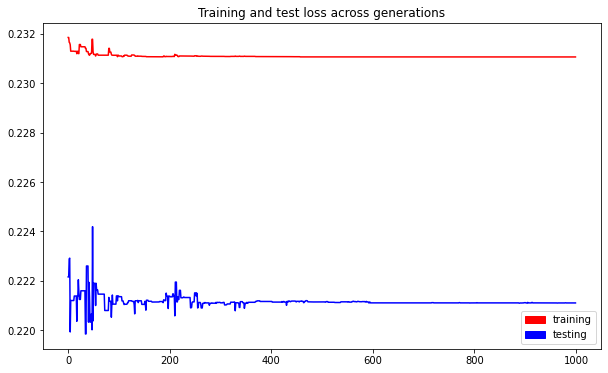

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'b')
plt.title("Training and test loss across generations")
plt.legend(handles=[red_patch,blue_patch])
plt.show()

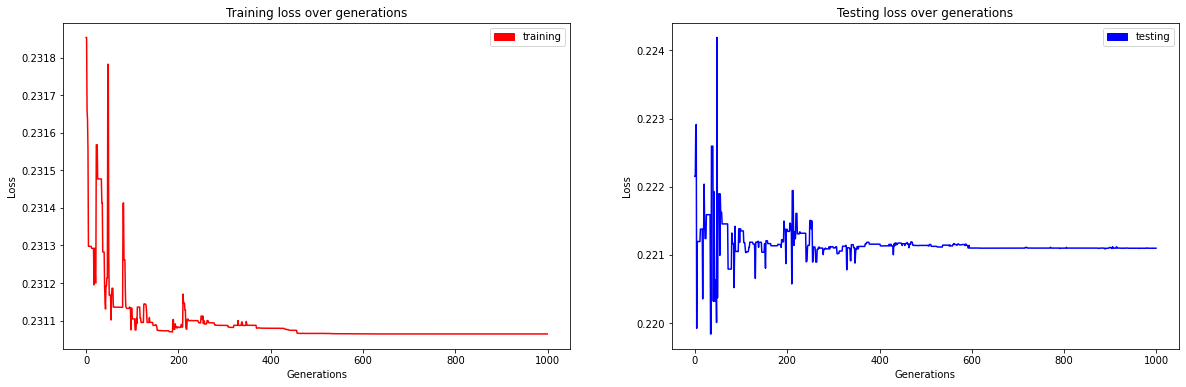

In [ ]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(train_losses, 'r')
plt.title("Training loss over generations")
plt.legend(handles=[red_patch])
plt.xlabel("Generations")
plt.ylabel("Loss")

ax = fig.add_subplot(1, 2, 2)
plt.plot(test_losses, 'b')
plt.title("Testing loss over generations")
plt.legend(handles=[blue_patch])
plt.xlabel("Generations")
plt.ylabel("Loss")
plt.show()

1.6

In [ ]:
x_values=data[data.columns.drop('y')]
x_values=x_values.values.tolist()
x_values = torch.as_tensor(x_values, dtype=torch.float32)
# get the predicted values
out =  mynet(x_values)  
y=pd.DataFrame(out.tolist(),columns=['y'])

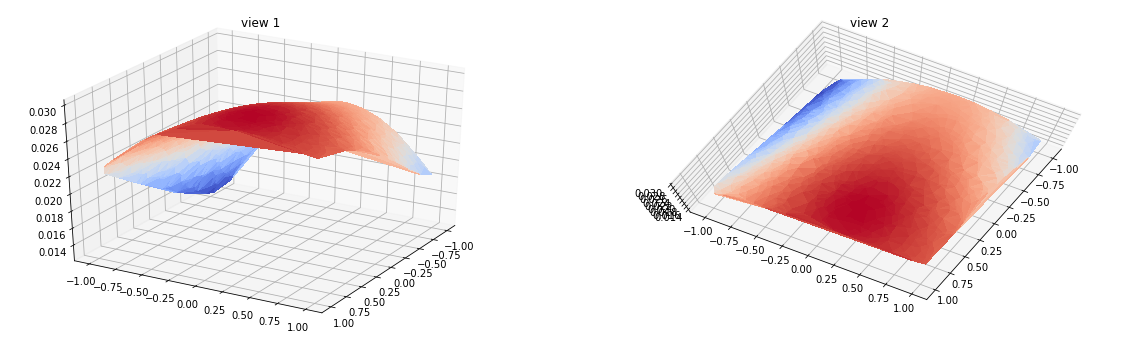

In [ ]:

# surface_plot with color grading and color bar
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(data['x1'], data['x2'],y['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
ax.view_init(30,30)
plt.title("view 1")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(data['x1'], data['x2'],y['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
plt.title("view 2")
ax.view_init(80,30)

1.7

In [ ]:
popSize     = 50 #Population size
dimension   = 67 #Numer of decision variable x 
numOfBits   = 30 #Number of bits in the chromosomes
iterations  = 100 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
omega       = 5
crossPoints = 2 #variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .1 #mutation prob
maxnum      = 2**numOfBits

In [ ]:
# commonly reused
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange= -20+40*numasint/maxnum

    # devide by 20 to fit it into the required range -1 to 1
    return numinrange

def separatevariables(v):
  
    v = v.reshape((67, 30))    
    # v is 67, 30 bit chromosomes   
    # the function then returns 67 decoded values 
    return [chrom2real(i) for i in v]

def real2chrome(weight):
  # setting required string lenth t to 30
    t=30
  # check if weighteight passed the limits
    if weight > 20:
        weight = 20
    elif weight < -20:
        weight = -20
    numinrange= (weight+20)*maxnum/40
    binary_rep=bin(int(numinrange))[2:]
    grayValues=bin_to_gray(binary_rep)
    lengrayval=len(grayValues)
    # chromosome length is not always 30 we add 0s to the beginning if less than 30
    if lengrayval<t:
        dif =t-lengrayval
        return ('0'*dif)+grayValues
    elif lengrayval==t:
        return grayValues



In [ ]:
real2chrome(-0.96969697)

'010001010010111010100000010100'

In [ ]:
chrom2real("010001010010111010100000010100")

-0.9696969762444496

In [ ]:
# generating random weights 
sample_weights = np.linspace(-1, 1, 67)
# sample_weights

In [ ]:
# chromosome values of the sample weights
genotypes = [real2chrome(i) for i in sample_weights]
# genotypes

In [ ]:
# the reversed chromosome/ decoded values
phenotypes = [chrom2real(i) for i in genotypes]
# phenotypes

In [ ]:
res2=pd.DataFrame(list(zip(sample_weights,genotypes, phenotypes)),columns=["sample weights",'genotypes','phenotypes'])
res2

,sample weights,genotypes,phenotypes
0,-1.000000,010001010101010101010101010101,-1.000000
1,-0.969697,010001010010111010100000010100,-0.969697
2,-0.939394,010001010000001010010111010100,-0.939394
3,-0.909091,010001110011100111001110011100,-0.909091
4,-0.878788,010001110101000000101001011101,-0.878788
...,...,...,...
62,0.878788,110001110101000000101001011101,0.878788
63,0.909091,110001110011100111001110011100,0.909091
64,0.939394,110001010000001010010111010100,0.939394
65,0.969697,110001010010111010100000010100,0.969697


# 1.8

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 50 #Population size
dimension   = 67 #Numer of decision variable x 
numOfBits   = 30 #Number of bits in the chromosomes
iterations  = 50 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
omega       = 5
crossPoints = 2 #variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .1 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....

optimizer = torch.optim.Rprop(mynet.parameters(), lr=0.02)
loss_func = torch.nn.MSELoss()

toolbox = base.Toolbox()


# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresultponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, numOfBits*dimension)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation
toolbox.register("select", tools.selRoulette, fit_attr='fitness')

def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange= -20+40*numasint/maxnum

    # devide by 20 to fit it into the required range -1 to 1
    return numinrange/20

# out is supposed to be the individual 
def eval_sphere(ind):
    result2 = []
    ind = np.asarray(ind)
#   get weights
    weights =np.asarray(separatevariables(ind))
    
    weightsIntoNetwork(weights)    
    result = ''
    # 
    for t in range(30):
        result2 =[]
        out =  mynet(x_train)
        # compute loss
        loss = loss_func(out,y_train)
        # initialize gradient
        optimizer.zero_grad()
        loss.backward()  # backpropagation and computing of gradients
        optimizer.step()  # apply gradients, go down gradient
        learnt_weights = weightsOutofNetwork(mynet)
                    
        # converting new weights to chromosomes()
        for i in learnt_weights:
            result = result + real2chrome(i)

        for i in list(result.strip(" ")):
            result2.append(int(i))

        # re init the result   
        result = ''   
    return (1/(0.01+loss.item()),creator.Individual(result2))


# register the goal / fitness function
toolbox.register("evaluate", eval_sphere)

def initializePopulation(l,t,individuals):   
    return individuals


# # this will help update the population

def main():
    # create an initial population of individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=popSize)
    

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))

    # unpacking the fitnesses to assign to the individuals
    fitnesses = [(i[0],) for i in fitnesses]
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    
    print("  Evaluated %i individuals" % len(pop))


    # Variable keeping track of the number of generations
    g = 0
    train_losses = []
    test_losses = []
    # Begin the evolution
      
    while g < iterations:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        

        ind_fitnesses = list(map(toolbox.evaluate, pop))

        fitnesses = [(i[0],) for i in ind_fitnesses]
        individuals = [i[1] for i in ind_fitnesses]

        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        
        # this will update the population
        toolbox.register("updatePop",initializePopulation,list,creator.Individual,individuals)

        # update population
        offspring = toolbox.updatePop()

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
#          # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        print("Invalid Ind: ",len(invalid_ind))
        fitnesses = map(toolbox.evaluate, invalid_ind)
        
        # have to unpack the fitnesses and individuals
        fitnesses = [(i[0],) for i in ind_fitnesses]
        individuals = [i[1] for i in ind_fitnesses]

        print("fitnesses after: ",len(fitnesses))
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        pop[:] = offspring  # The population is entirely replaced by the offspring

        best_ind = tools.selBest(pop, 1)[0]
        # get the inverse for roullete selection
        train_losses.append(1/best_ind.fitness.values[0])
       
    
        eval_sphere(best_ind) # input the best weights into the network
        out =  mynet(x_test)  # input x and predict based on x
        loss = loss_func(out,y_test)
        test_losses.append(loss.item())


    print("------Successfull evolution-----")
    return train_losses,test_losses,best_ind
        
    
if __name__ == "__main__":
    
    train_losses,test_losses,best_ind = main()

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Evaluated 50 individuals
-- Generation 1 --
Invalid Ind:  50
fitnesses after:  50


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-- Generation 2 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 3 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 4 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 5 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 6 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 7 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 8 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 9 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 10 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 11 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 12 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 13 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 14 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 15 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 16 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 17 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 18 --
Invalid Ind:  50
fitnesses after:  50
-- Generation 19 --
In

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


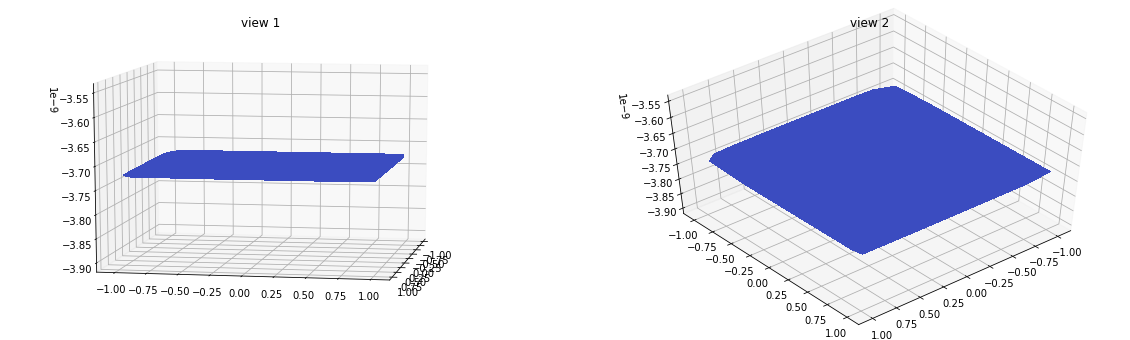

In [ ]:
eval_sphere(best_ind)
out =  mynet(x_values)  
y_values=pd.DataFrame(out.tolist(),columns=['y'])



# surface_plot with color grading and color bar
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(data['x1'], data['x2'],y_values['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
ax.view_init(10,10)
plt.title("view 1")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(data['x1'], data['x2'],y_values['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
plt.title("view 2")
ax.view_init(50,50)
plt.show()

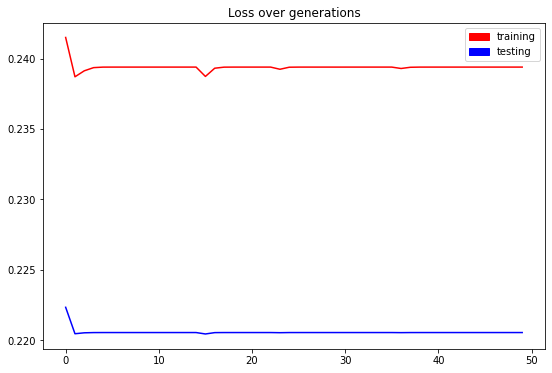

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'b')
plt.title("Loss over generations")
plt.legend(handles=[red_patch,blue_patch])
plt.show()

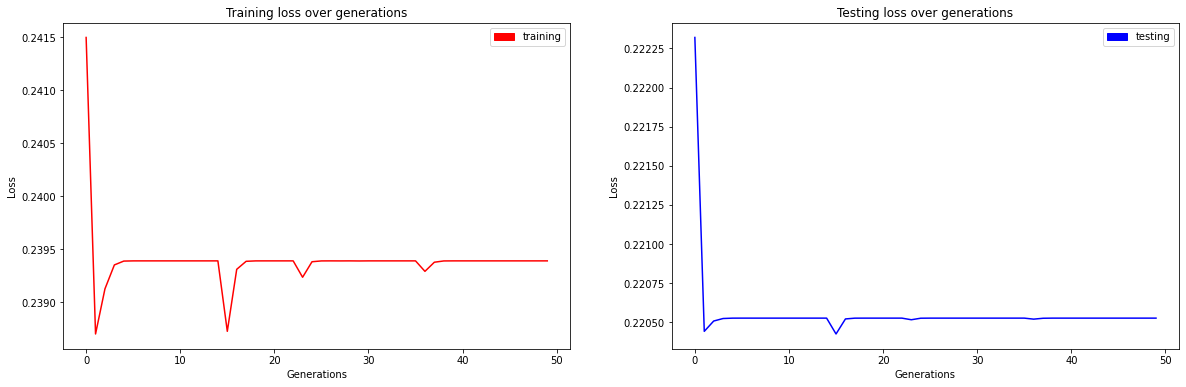

In [ ]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(train_losses, 'r')
plt.title("Training loss over generations")
plt.legend(handles=[red_patch])
plt.xlabel("Generations")
plt.ylabel("Loss")

ax = fig.add_subplot(1, 2, 2)
plt.plot(test_losses, 'b')
plt.title("Testing loss over generations")
plt.legend(handles=[blue_patch])
plt.xlabel("Generations")
plt.ylabel("Loss")
plt.show()

# 1.9

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 50 #Population size
dimension   = 67 #Numer of decision variable x 
numOfBits   = 30 #Number of bits in the chromosomes
iterations  = 100 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
omega       = 5
crossPoints = 2 #variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .1 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....


optimizer = torch.optim.Rprop(mynet.parameters(), lr=0.02)
loss_func = torch.nn.MSELoss()
toolbox = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, numOfBits*dimension)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def eval_sphere(ind):
    weights =np.asarray(separatevariables(np.asarray(ind)))
    
    weightsIntoNetwork(weights)
    
    for t in range(30): 
        out =  mynet(x_train)
        loss = loss_func(out,y_train)
        # initialize gradient
        optimizer.zero_grad()
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
        # print("what is: ",t)
    return (1/(0.01+loss.item()),)

#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", eval_sphere)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selRoulette, fit_attr='fitness')

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange= -20+40*numasint/maxnum
    return numinrange/20

# input: concatenated list of binary variables
# output: tuple of real numbers representing those variables
# requires a loop or other method 

def separatevariables(v):

    
    v = v.reshape((67, 30))

    weights = [chrom2real(i) for i in v]
    return weights


def main():
    #random.seed(64)

    # create an initial population of individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=popSize)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))

    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(pop))



    # Variable keeping track of the number of generations
    g = 0
    train_losses = []
    test_losses = []

    # Begin the evolution
    while g < iterations:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)

        # Select the next generation individuals
        offspring = tools.selBest(pop, nElitists) + toolbox.select(pop,len(pop)-nElitists)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        
   
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
              
        # The population is entirely replaced by the offspring
        best_ind = tools.selBest(pop, 1)[0]
        train_losses.append(1/best_ind.fitness.values[0])
        pop[:] = offspring
    
        eval_sphere(best_ind)
        out =  mynet(x_test)  # input x and predict based on x
        loss = loss_func(out,y_test)
        test_losses.append(loss.item())
        
    best_ind = tools.selBest(pop, 1)[0]  
    print("-- End of (successful) evolution --")  
    
    return train_losses,best_ind,test_losses
    

if __name__ == "__main__":
    train_losses,best_ind,test_losses= main()


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Evaluated 50 individuals
-- Generation 1 --


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generation 50 --
-- Generation 51 --
-- Gener

In [ ]:
# train_losses

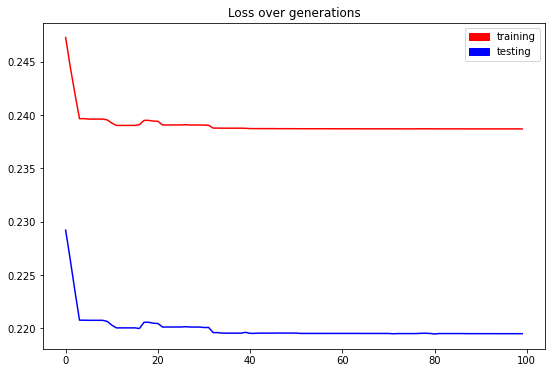

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'b')
plt.title("Loss over generations")
plt.legend(handles=[red_patch,blue_patch])
plt.show()

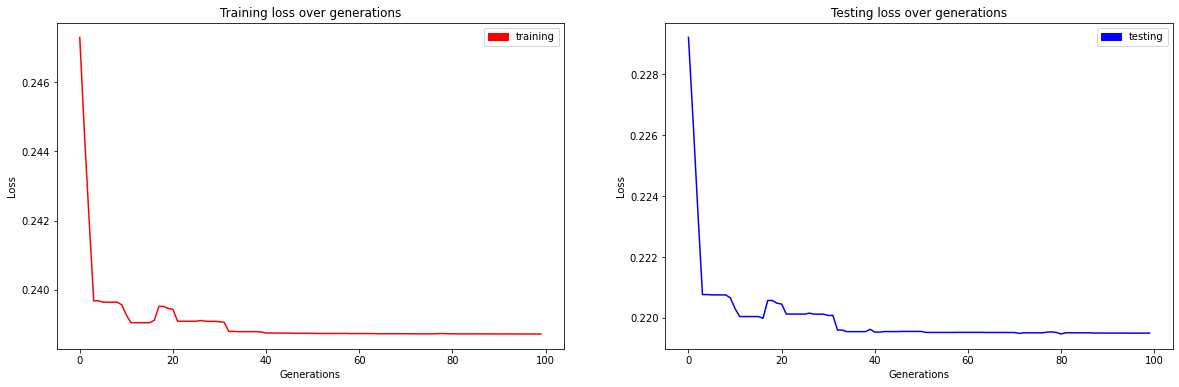

In [ ]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(train_losses, 'r')
plt.title("Training loss over generations")
plt.legend(handles=[red_patch])
plt.xlabel("Generations")
plt.ylabel("Loss")

ax = fig.add_subplot(1, 2, 2)
plt.plot(test_losses, 'b')
plt.title("Testing loss over generations")
plt.legend(handles=[blue_patch])
plt.xlabel("Generations")
plt.ylabel("Loss")
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


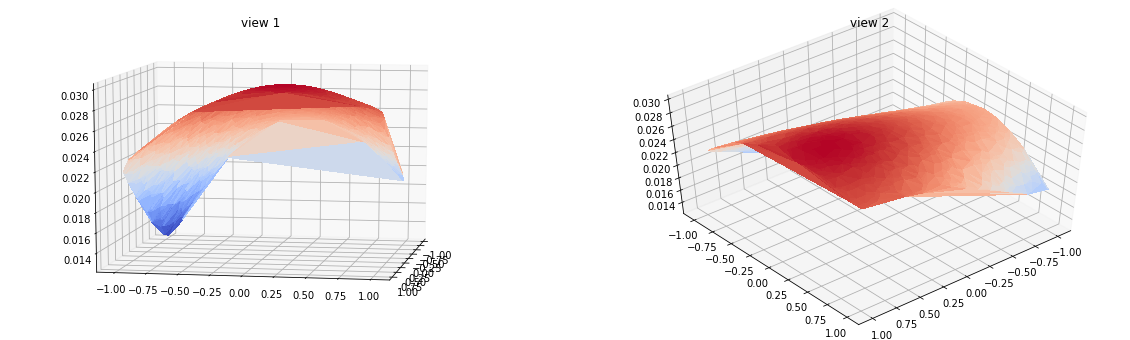

In [ ]:
eval_sphere(best_ind)
out =  mynet(x_values)  
y_values=pd.DataFrame(out.tolist(),columns=['y'])



# surface_plot with color grading and color bar
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(data['x1'], data['x2'],y_values['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
ax.view_init(10,10)
plt.title("view 1")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(data['x1'], data['x2'],y_values['y'],cmap=matplotlib.cm.coolwarm, linewidth=0,zorder=0, antialiased=False)
plt.title("view 2")
ax.view_init(50,50)
plt.show()